In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pdb
from sklearn.linear_model import LogisticRegression
import time



# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

import seaborn as sns
sns.set(style="ticks")

from sklearn.externals import joblib




In [5]:
train_df = pd.read_csv('train.csv')

#

# check for missing values in frame. 
train_df.isnull().values.any()
print("Raw training set shape:",train_df.shape)

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

### make a function out of this. We intend to verify that the binary features are mutually exclusive. 
soils_only_df = train_df[train_df.columns[15:-1]] # extract columns of soil types. leave out the class column.
sums = soils_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no soil type in this sample:", i)
wilderness_only_df = train_df[train_df.columns[11:15]] # extract columns of wilderness types
sums = wilderness_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no wilderness type in this sample:", i)
###

# Now, combine all soil columns into a single soil multifactor column. Ditto for Wilderness_Area* 
# Caveat: The train data's ID starts from 1, while panda's index starts from 0. 
# Don't forget to tag on the class column. 

### make a function out of this as well. will need it to transform actual test data. 
train_mod_df = train_df.iloc[:,:11].copy() # grab all rows from 0 thru 10. 
train_mod_df['WILDERNESS']=0 # Replaces Wilderness_Area* features. 
train_mod_df['SOILS']=0 # Replaces Soil_Type* features. 

for index, row in train_df.iterrows():
    for j in range(15,row.shape[0]-1): # make sure  you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'SOILS'] = j-14 # values start from 1

for index, row in train_df.iterrows():
    for j in range(11,15): # make sure  you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'WILDERNESS'] = j-10 # values start from 1

train_mod_df[target] = train_df[target] # Add back the Class column
###

Raw training set shape: (15120, 56)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [6]:
# So we don't have to change the frame's name in the cells below ...
train_df = train_mod_df
train_df.shape

(15120, 14)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WILDERNESS', 'SOILS']


C:\tools\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


After split, Train and Dev dataset shapes are: (12096, 14) (3024, 14)


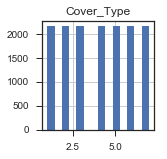

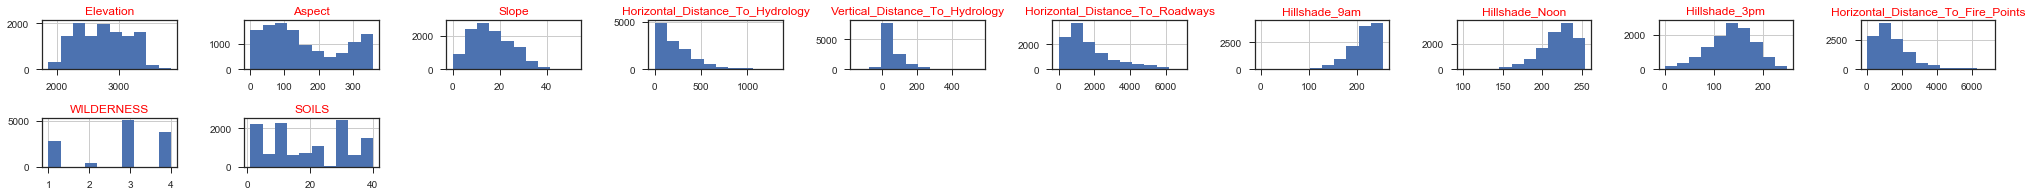

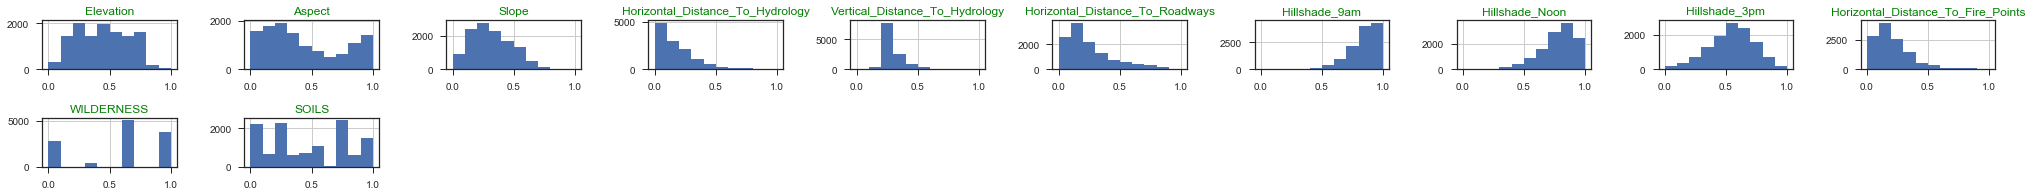

In [7]:
# Get predictors out again

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# should we be splitting after normalization. Or before? Before makes sense cause dev data should be a surrogate for actual - 
# - kaggle test data we have not seen yet. 
plt.figure(figsize=(2, 2))
ax = train_df['Cover_Type'].hist(bins=14) # Check to see if any stratification is required for train,dev split. 
ax.set_title('Cover_Type')
train_df, dev_df = train_test_split(train_df,test_size=0.2)

# display histograms for basic EDA. titles in Red. 
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    ax.set_title(predictors[i],color='Red') 

# Need to store these values for normalizing new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# going with min-max. tries z-scores before, but now doubt it will work well for SOIL and WILDERNESS
train_df[predictors] = (train_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])
dev_df[predictors] = (dev_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])

print("After split, Train and Dev dataset shapes are:",train_df.shape, dev_df.shape)

# display histograms post normalization. Titles in Green.
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    aax = data.hist()
    aax.set_title(predictors[i],color='Green') 
    
#spm = pd.plotting.scatter_matrix(train_df[predictors[0:10]], alpha=0.5, figsize=(15,15), diagonal='hist')
#sns.pairplot(train_df[predictors[10:]])

In [10]:
# Next, evaluate a Random Forest with 500 trees. 
rf = RandomForestClassifier(n_estimators=500, oob_score=True, criterion="entropy")
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

Mean R^2 = 0.856


In [11]:
rf.fit(train_df[predictors], train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.862764550265
             precision    recall  f1-score   support

          1       0.77      0.77      0.77       408
          2       0.80      0.69      0.74       426
          3       0.86      0.80      0.83       425
          4       0.93      0.96      0.95       443
          5       0.90      0.96      0.93       427
          6       0.82      0.87      0.84       432
          7       0.94      0.97      0.95       463

avg / total       0.86      0.86      0.86      3024



In [15]:
param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto']},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(train_df[predictors], train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 2698.4889414310455
Best params from grid search are: {'bootstrap': False, 'max_features': 4, 'n_estimators': 250}


In [17]:
rf = RandomForestClassifier(**grid_search.best_params_)
rf.fit(train_df[predictors],train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(rf, "rf.pkl")

0.871693121693
             precision    recall  f1-score   support

          1       0.78      0.78      0.78       408
          2       0.79      0.71      0.75       426
          3       0.88      0.83      0.86       425
          4       0.95      0.96      0.95       443
          5       0.91      0.96      0.93       427
          6       0.83      0.88      0.86       432
          7       0.95      0.97      0.96       463

avg / total       0.87      0.87      0.87      3024



['rf.pkl']

In [8]:
param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)


start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(train_df[predictors],train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 634.7191932201385
Randomized grid search best params are: {'n_estimators': 250, 'max_features': 4}


In [9]:
random_rf = RandomForestClassifier(**random_search.best_params_)
random_rf.fit(train_df[predictors],train_df[target])
print(random_rf.score(dev_df[predictors], dev_df[target]))
dev_pred = random_rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(random_rf, "random_rf.pkl")

0.869708994709
             precision    recall  f1-score   support

          1       0.78      0.75      0.77       428
          2       0.79      0.70      0.74       442
          3       0.86      0.87      0.87       423
          4       0.92      0.97      0.94       407
          5       0.90      0.95      0.92       438
          6       0.89      0.88      0.89       451
          7       0.93      0.98      0.95       435

avg / total       0.87      0.87      0.87      3024



['random_rf.pkl']

In [20]:
lsvc = LinearSVC(C=1)
lsvc.fit(train_df[predictors],train_df[target])
dev_pred = lsvc.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.55      0.44      0.49       408
          2       0.51      0.42      0.46       426
          3       0.51      0.48      0.50       425
          4       0.75      0.90      0.82       443
          5       0.61      0.55      0.58       427
          6       0.51      0.55      0.53       432
          7       0.75      0.91      0.82       463

avg / total       0.60      0.61      0.60      3024



In [21]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=4)
softmax_reg.fit(train_df[predictors], train_df[target])
dev_pred = softmax_reg.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.61      0.60      0.60       408
          2       0.59      0.47      0.52       426
          3       0.60      0.46      0.52       425
          4       0.77      0.86      0.81       443
          5       0.64      0.76      0.69       427
          6       0.59      0.64      0.61       432
          7       0.81      0.88      0.84       463

avg / total       0.66      0.67      0.66      3024



In [22]:
voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf)],
    voting='hard')
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\tools\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


             precision    recall  f1-score   support

          1       0.72      0.78      0.75       408
          2       0.77      0.63      0.69       426
          3       0.81      0.79      0.80       425
          4       0.92      0.97      0.95       443
          5       0.89      0.94      0.91       427
          6       0.82      0.82      0.82       432
          7       0.94      0.96      0.95       463

avg / total       0.84      0.84      0.84      3024



In [ ]:
n_estimators_start = 100
n_estimators_end = 2501 # May take a while. 
n_estimators = [i for i in range(n_estimators_start,n_estimators_end)]
voter_models = [(str(k),RandomForestClassifier(n_estimators = k, max_features='auto', oob_score=True)) for k in n_estimators]
voter_models.append(('rrf', random_rf)) # append any tuples here. 
voter = VotingClassifier(
    estimators= voter_models,
    voting='soft')
start_time = time.time()
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
end_time = time.time()
print(classification_report(dev_df[target],dev_pred))
print(voter.score(dev_df[predictors], dev_df[target]))
print("Wallclock time in secs for Voter:",end_time - start_time)
#print("Voter params: ", voter.get_params(deep=False)) # unfortunately, unable to extract winning candidate. 
